Imported libraries

In [1]:
import pandas as pd

# For Data
from Data.historical_data import Historical_data
from alpaca.data.timeframe import TimeFrame
from alpaca.data.historical import CryptoHistoricalDataClient, StockHistoricalDataClient

# For preprocessing
from Preprocessing.preprocessing import Preprocessing

# For model
from Models.LSTM.lstm import LSTM

# For training and evaluation
from Evaluation.evaluation import Evaluator_LSTM
import time
import matplotlib.pyplot as plt

Data and Preprocessing

In [2]:
new_data = False

if new_data:

    stocks = [['AAPL'], ['MSFT'], ['GOOG'], ['TSLA'], ['NVDA']]

    for stock in stocks:

        timeframes = [TimeFrame.Day, TimeFrame.Hour, TimeFrame.Minute]
        time_strings = ['Day', 'Hour', 'Minute']

        for timeframe, time_string in zip(timeframes, time_strings):

            s_type = "StockBars"
            stock = stock
            timeframe = timeframe
            start = "2020-08-20 06:00:00"
            end = "2021-08-20 06:00:00"
            client = StockHistoricalDataClient("PKV7BABG3DGE0GYL137W", "af1eQghpVgbyX2lh2T9n2ColmVYXHCWndQbKR3Lr")
            save_csv = True
            time_string = time_string

            df = Historical_data(s_type = s_type, stock = stock, timeframe = timeframe, start = start, end = end, client = client, save_csv = save_csv , time_string = time_string)

else:

    df = pd.read_csv('Data\Stock\StockBars\MSFT_Hour')

df_tuple = Preprocessing(df, lag = 1, dif_all = False)

The diff of one and zero prior to scaling is is: 2.01%
The diff of one and zero post scaling is: 0.00%


In [3]:
df_tuple

(tensor([[[ 2.3607e+01,  2.3988e+01,  2.3352e+01,  ..., -2.2916e-01,
           -8.2893e-02,  2.3726e+01]],
 
         [[ 2.3745e+01,  2.4102e+01,  2.3474e+01,  ..., -2.2826e-01,
           -8.0754e-02,  2.3844e+01]],
 
         [[ 2.3849e+01,  2.4106e+01,  2.3493e+01,  ..., -2.1855e-01,
           -5.9027e-02,  2.3859e+01]],
 
         ...,
 
         [[-3.3160e-02, -3.4618e-02, -3.6953e-02,  ...,  5.9416e-01,
            8.2300e-01, -3.1661e-02]],
 
         [[-1.2149e-02, -3.1406e-02, -1.6015e-02,  ...,  3.1390e-01,
            5.1388e-01, -1.5716e-02]],
 
         [[-3.0338e-02, -3.8772e-02, -1.0465e-02,  ...,  1.4511e-01,
            3.4851e-01, -1.7864e-02]]]),
 tensor([[[-1.5522e-02, -3.5689e-02,  6.9723e-04,  ...,  9.2341e-02,
            3.0541e-01, -1.2091e-02]],
 
         [[-1.6933e-02, -3.4261e-02,  1.3945e-03,  ...,  1.5447e-01,
            3.6013e-01, -1.0693e-02]],
 
         [[-1.5169e-02, -3.8544e-02, -2.1614e-02,  ...,  6.8547e-01,
            7.8544e-01, -2.3059e-02

Create model

In [4]:
input_size = 7 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
num_classes = 1 #number of output classes 

lstm_1 = LSTM(input_size, hidden_size, num_layers, df_tuple[0].shape[1]) #our lstm class 

input_size = 7 #number of features
hidden_size = 4 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
num_classes = 1 #number of output classes 

lstm_2 = LSTM(input_size, hidden_size, num_layers, df_tuple[0].shape[1]) #our lstm class 

input_size = 7 #number of features
hidden_size = 8 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
num_classes = 1 #number of output classes 

lstm_3 = LSTM(input_size, hidden_size, num_layers, df_tuple[0].shape[1]) #our lstm class 

models = [lstm_1, lstm_2, lstm_3]

Train and Evaluate Model

Epoch 0, Loss: 191.99217224121094
Epoch 100, Loss: 190.59893798828125
Epoch 200, Loss: 189.68527221679688
Epoch 300, Loss: 188.9946746826172
Epoch 400, Loss: 188.57199096679688
Epoch 500, Loss: 188.27191162109375
Epoch 600, Loss: 188.06309509277344
Epoch 700, Loss: 187.9226531982422
Epoch 800, Loss: 187.85401916503906
Epoch 900, Loss: 187.77833557128906
Accuracy: 0.7183622717857361


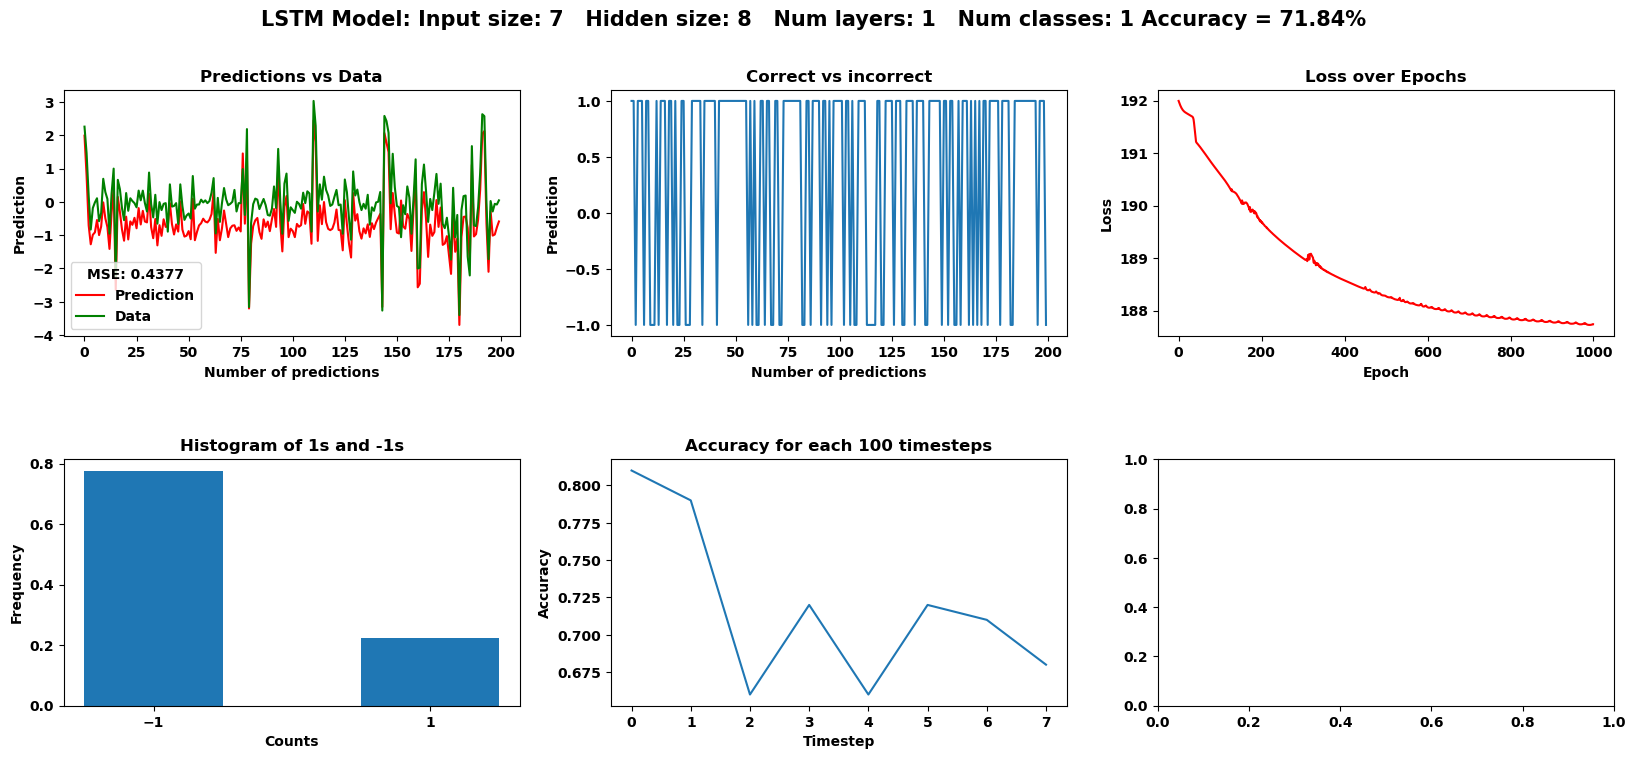

Epoch 0, Loss: 191.74940490722656
Epoch 100, Loss: 191.17237854003906
Epoch 200, Loss: 189.60418701171875
Epoch 300, Loss: 188.18212890625
Epoch 400, Loss: 187.49667358398438
Epoch 500, Loss: 187.16940307617188
Epoch 600, Loss: 186.9061279296875
Epoch 700, Loss: 186.67515563964844
Epoch 800, Loss: 186.50111389160156
Epoch 900, Loss: 186.34536743164062
Accuracy: 0.9143920540809631


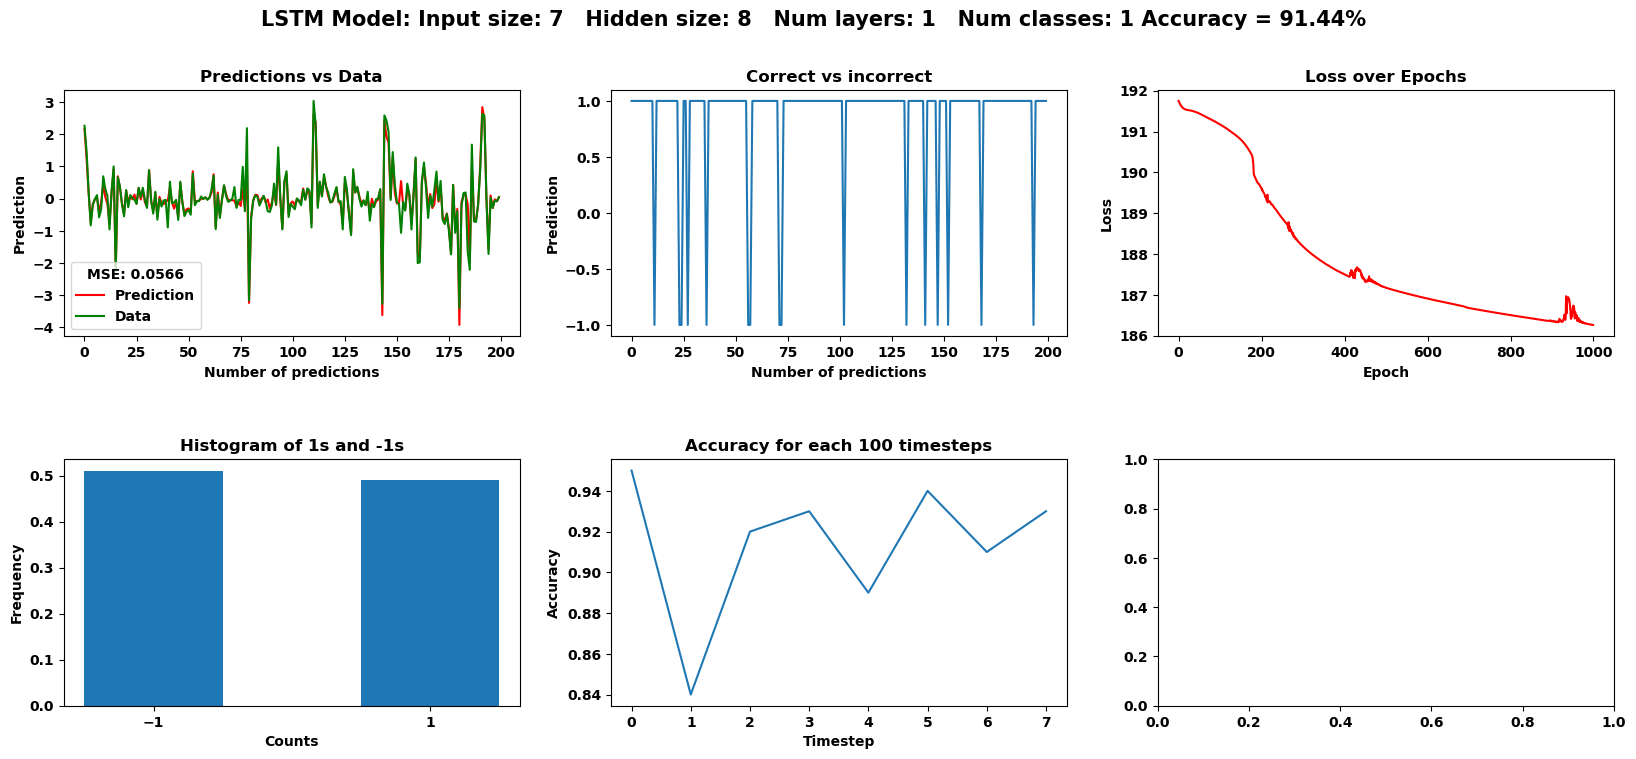

Epoch 0, Loss: 191.75198364257812
Epoch 100, Loss: 189.65353393554688
Epoch 200, Loss: 188.00112915039062
Epoch 300, Loss: 187.1873016357422
Epoch 400, Loss: 186.91038513183594
Epoch 500, Loss: 186.6342010498047
Epoch 600, Loss: 186.45396423339844
Epoch 700, Loss: 186.2353973388672
Epoch 800, Loss: 186.10604858398438
Epoch 900, Loss: 185.8702392578125
Accuracy: 0.8945409655570984


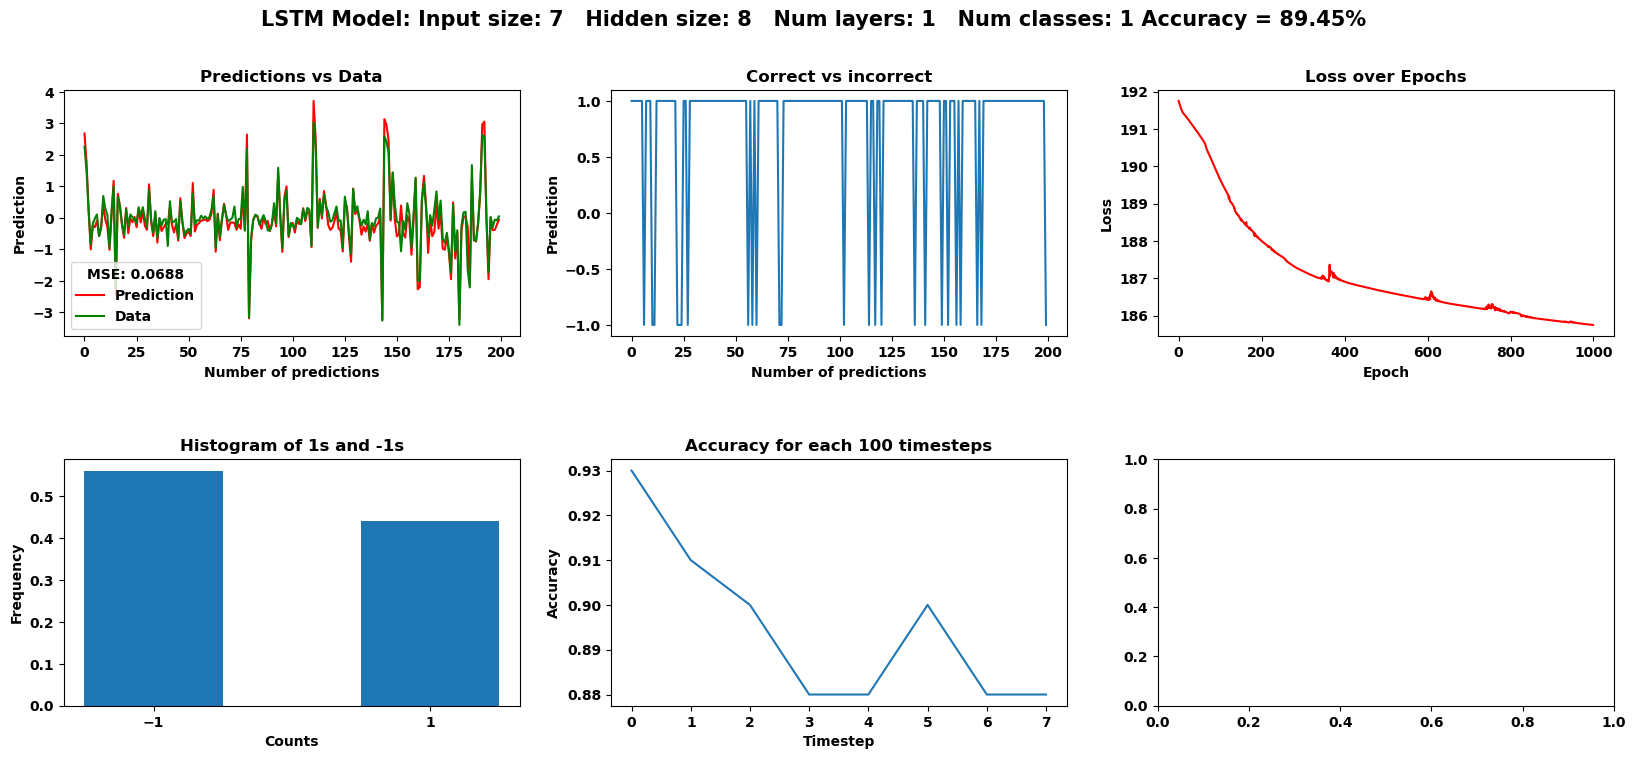

,Model,Loss,Time,Accuracy
0,model_1,187.739609,3.676664,[tensor(0.7184)]
1,model_2,186.260849,4.569281,[tensor(0.9144)]
2,model_3,185.749374,4.871200,[tensor(0.8945)]


In [5]:
model_text = 'Input size: ' + str(input_size) + '   Hidden size: ' + str(hidden_size) + '   Num layers: ' + str(num_layers) + '   Num classes: ' + str(num_classes)
loss_list = []
time_list = []
acc_list = []
for model in models:
    start_time = time.time()
    loss, accuracy= Evaluator_LSTM(model = model, data = df_tuple, learning_rate = 0.01 , num_epochs = 1000, epoch_vis = True, visualize = True, model_text = model_text)
    end_time = time.time()
    time_list.append(end_time - start_time)
    loss_list.append(loss)
    acc_list.append(accuracy)

model_names = ["model_1", "model_2", "model_3"]
df = pd.DataFrame({"Model": model_names, "Loss": loss_list, "Time": time_list, "Accuracy": acc_list})
df
